In [0]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [3]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from sklearn.cross_validation import StratifiedShuffleSplit

#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [0]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 32, 32, 3)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
Range before: 255 0
Range after: 1.0 0.0


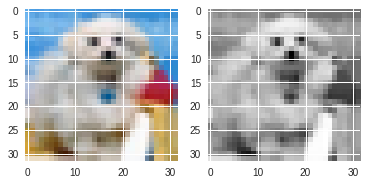

In [41]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_data.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

# Prepare the data
# Normalizes values from the range of 0-255 to 0-1.0
print("Range before:",np.amax(trainVal_data), np.amin(trainVal_data))
trainVal_data = trainVal_data / 255
X_test = X_test / 255
print("Range after:", np.amax(trainVal_data), np.amin(trainVal_data))

# Converts to grayscale, reducing to a 1-dimensional channel
r = np.asarray(0.299)
g = np.asarray(0.587)
b = np.asarray(0.114)
trainVal_data_grayscale = r * trainVal_data[:, :, :, 0] + g * trainVal_data[:, :, :, 1] + b * trainVal_data[:, :, :, 2]
X_test_grayscale =  r * X_test[:, :, :, 0] + g * X_test[:, :, :, 1] + b * X_test[:, :, :, 2]

# Optional: Converts to 1-dimensional list with only one element (grayscale val)
# trainVal_data_grayscale = np.expand_dims(trainVal_data_grayscale, axis=3)
# X_test_grayscale = np.expand_dims(X_test_grayscale, axis=3)


# Print random image
img = np.random.randint(1, 50000)
plt.subplot(1, 2, 1)
plt.imshow(trainVal_data[img])
plt.subplot(1, 2, 2)
plt.imshow(trainVal_data_grayscale[img], cmap=plt.get_cmap('gray'))
plt.show()


-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [0]:
squeezeNetModel = SqueezeNet((32,32,3))

#freeze layers
for layer in squeezeNetModel.layers:
    layer.trainable = False

#Add new classification layers
# ...

#new Model
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

Now, we compile our model and train it:

In [0]:
# Compile model and train it.
# ...

Finally, let's evaluate on our test set:

In [0]:
# Evaluate on validation:
# ...
print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [0]:
squeezeNetModel = SqueezeNet((32,32,3))

print([layer.name for layer in squeezeNetModel.layers])

#freeze the mentioned layers
# ...

#Add new classification layers
# ...

#new Model
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

Now, we compile our model and train it:

In [0]:
#Compile model and train it
# ...

Finally, let's evaluate on our test set:

In [0]:
# Evaluate on validation.
print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

## Just an example, DON'T RUN! 
### You will need to change <<LOG_DIR>>
import keras.callbacks as callbacks
tbCallBack = callbacks.TensorBoard(log_dir = "./<<LOG_DIR>>")
model.fit(..., callbacks=[tbCallBack])

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

$ docker run -it -p <<port_host>>:<<port_container>>
            --volume=<<LOG_DIR>>:<<LOG_DIR>>
            --name=<<container_name>> <<docker_image>> 
            tensorboard --logdir=<<LOG_DIR>> --port=<<port_container>>

For example:

$ docker run -it -p 8887:8887
            --volume=/your/path/ml2018/:/ml2018
            --name=mdc_container_tensorboard mdc-keras:cpu
            tensorboard --logdir=/ml2018/logs --port=8887

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [0]:
squeezeNetModel = SqueezeNet((32,32,3))

for layer in squeezeNetModel.layers:
    layer.trainable = True       #by default they are all trainable, but just for clarification

#Add new classification layers
# ...

#new Model
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

Now, we compile our model and train it:

In [0]:
from time import time

#Compile model
# ...

#Tensorboard callback
#tbCallBack = TensorBoard(log_dir="./logs/rafa", write_graph=True)
tbCallBack = TensorBoard(log_dir="/TransferLearning/logs/{}".format(time()), write_graph=True)

#Train model
# ...

Finally, let's evaluate on our validation set:

In [0]:
# Evaluate on validation
# ...
print('Validation loss:', score[0])
print('Validation accuracy (NORMALIZED):', score[1])

In [0]:
# Evaluate your best model on test
# ...

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [0]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [0]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])